Importation des bibliothèques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
import string

In [2]:
#Récupération des données
df=pd.read_csv("movies2024.csv")
df.head(10)

,MovieID,Title,Popularity,Overview,Genres,Actors,Directors,VoteAverage,ReleaseYear
0,533535,Deadpool & Wolverine,5948.017,A listless Wade Wilson toils away in civilian ...,"Action, Comedy, Science Fiction","Ryan Reynolds, Hugh Jackman, Emma Corrin, Matt...",Shawn Levy,7.763,2024.0
1,1022789,Inside Out 2,3128.461,Teenager Riley's mind headquarters is undergoi...,"Animation, Family, Adventure, Comedy","Amy Poehler, Maya Hawke, Kensington Tallman, L...",Kelsey Mann,7.678,2024.0
2,519182,Despicable Me 4,2384.852,"Gru and Lucy and their girls—Margo, Edith and ...","Animation, Family, Comedy, Action","Steve Carell, Kristen Wiig, Will Ferrell, Sofí...",Chris Renaud,7.297,2024.0
3,718821,Twisters,2251.448,"As storm season intensifies, the paths of form...","Action, Adventure, Drama, Thriller","Daisy Edgar-Jones, Glen Powell, Anthony Ramos,...",Lee Isaac Chung,7.039,2024.0
4,704239,The Union,1791.389,A New Jersey construction worker goes from reg...,"Action, Comedy","Mark Wahlberg, Halle Berry, J.K. Simmons, Mike...",Julian Farino,6.368,2024.0
5,573435,Bad Boys: Ride or Die,1745.309,"After their late former Captain is framed, Low...","Action, Crime, Thriller, Comedy","Will Smith, Martin Lawrence, Vanessa Hudgens, ...","Adil El Arbi, Bilall Fallah",7.597,2024.0
6,1094138,Jackpot!,1588.189,"In the near future, a 'Grand Lottery' has been...","Action, Comedy, Science Fiction","Awkwafina, John Cena, Simu Liu, Ayden Mayeri, ...",Paul Feig,6.487,2024.0
7,1160018,Kill,1498.700,When an army commando finds out his true love ...,"Action, Crime","Lakshya Lalwani, Raghav Juyal, Tanya Maniktala...",Nikhil Nagesh Bhat,6.970,2024.0
8,945961,Alien: Romulus,1335.187,While scavenging the deep ends of a derelict s...,"Horror, Science Fiction","Cailee Spaeny, David Jonsson, Archie Renaux, I...",Fede Álvarez,7.282,2024.0
9,1079091,It Ends with Us,1307.713,Lily Bloom overcomes a traumatic childhood to ...,"Romance, Drama","Blake Lively, Justin Baldoni, Brandon Sklenar,...",Justin Baldoni,7.053,2024.0


Visualisation des données

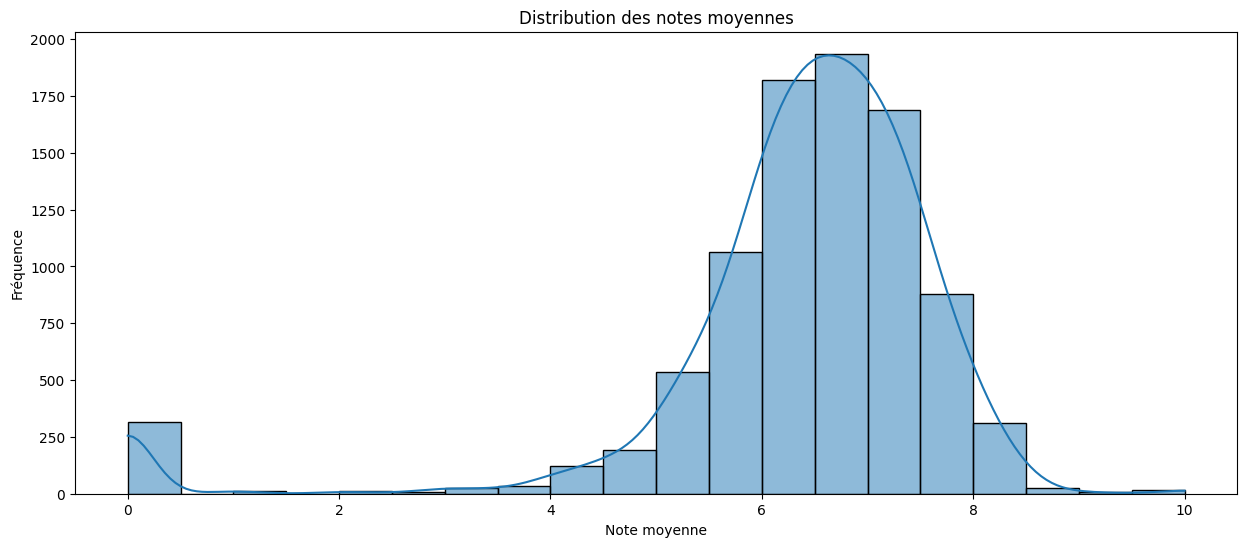

In [3]:
# Histogramme des notes moyennes
plt.figure(figsize=(15, 6))
sns.histplot(df['VoteAverage'], bins=20, kde=True)
plt.title('Distribution des notes moyennes')
plt.xlabel('Note moyenne')
plt.ylabel('Fréquence')
plt.show()

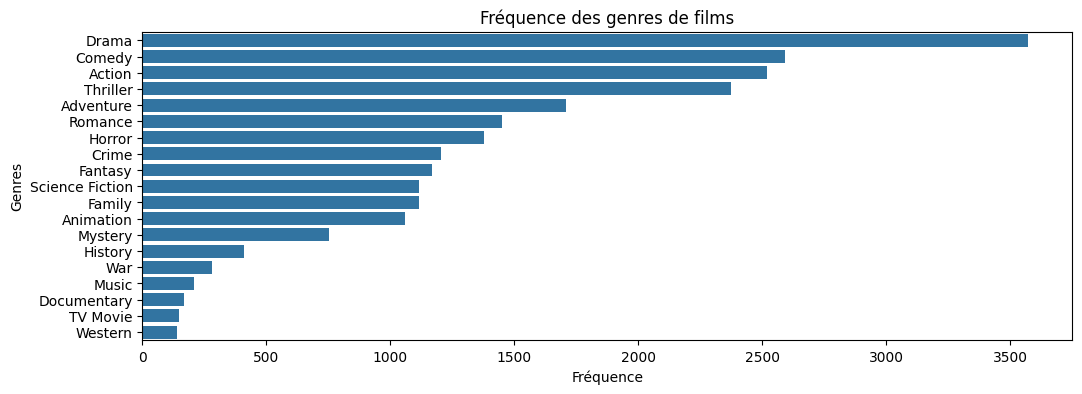

In [4]:
# Diagramme à barres pour les genres de films
plt.figure(figsize=(12, 4))
genre_counts = df['Genres'].str.strip().str.split(',').explode().str.strip().value_counts()
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Fréquence des genres de films')
plt.xlabel('Fréquence')
plt.ylabel('Genres')
plt.show()

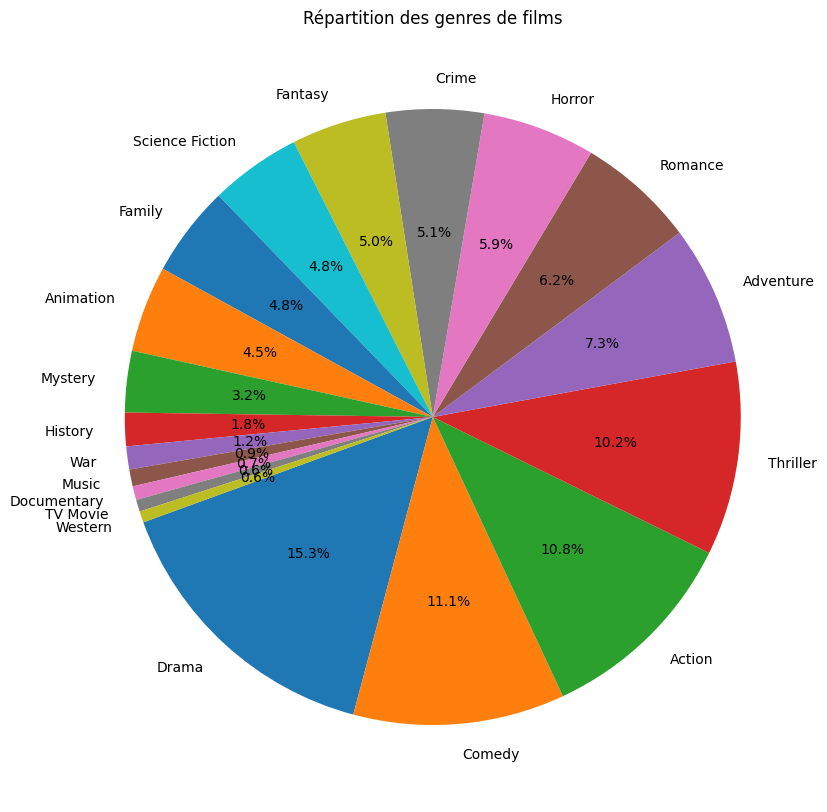

In [5]:
# Afficher le diagramme à secteurs
plt.figure(figsize=(18, 10))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=200)
plt.title('Répartition des genres de films')
plt.show()

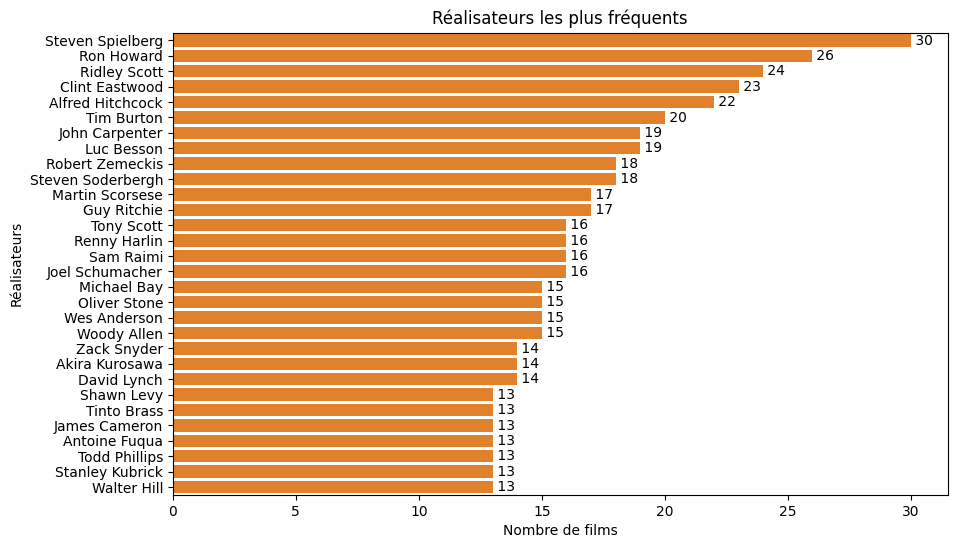

In [6]:
# Afficher le graphique à barres des réalisateurs les plus fréquents et compter leur fréquence
plt.figure(figsize=(10, 6))
director_counts = df['Directors'].str.strip().value_counts().head(30)
sns.barplot(x=director_counts.values, y=director_counts.index)
bar_plot = sns.barplot(x=director_counts.values, y=director_counts.index)
plt.title('Réalisateurs les plus fréquents')
plt.xlabel('Nombre de films')
plt.ylabel('Réalisateurs')
# Afficher les valeurs exactes à côté des barres
for index, value in enumerate(director_counts.values):
    bar_plot.text(value, index, f' {value}', ha='left', va='center')
plt.show()

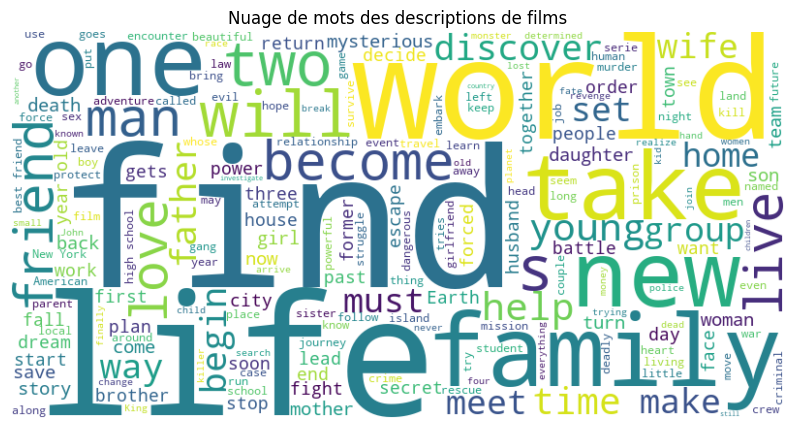

In [7]:
# Concaténer toutes les descriptions de films
text = ' '.join(df['Overview'].fillna(''))
# Créer et afficher le nuage de mots
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots des descriptions de films')
plt.show()

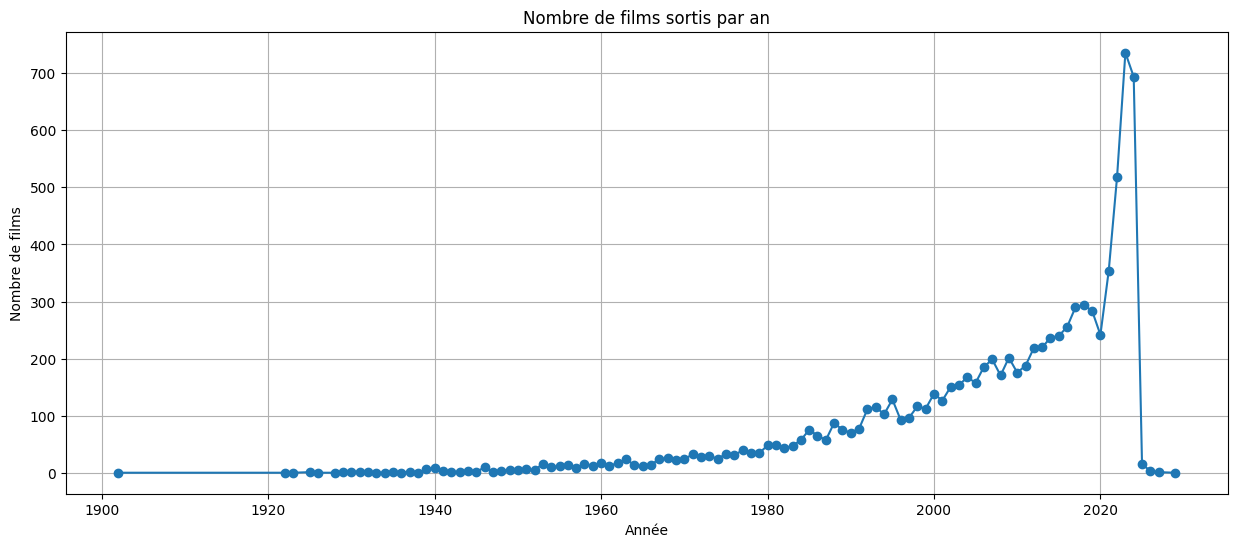

In [8]:
# Convertir la colonne ReleaseYear en datetime et compter les sorties par année
df['ReleaseYear'] = pd.to_datetime(df['ReleaseYear'], format='%Y')
yearly_counts = df['ReleaseYear'].dt.year.value_counts().sort_index()
# Afficher le graphique temporel
plt.figure(figsize=(15, 6))
yearly_counts.plot(marker='o')
plt.title('Nombre de films sortis par an')
plt.xlabel('Année')
plt.ylabel('Nombre de films')
plt.grid(True)
plt.show()

Préprocessing

In [9]:
# Compter les valeurs manquantes par colonne
missing_values_count = df.isna().sum()
# Afficher les colonnes avec des valeurs manquantes et leur décompte respectif
print(missing_values_count[missing_values_count > 0])


Overview       66
Genres         72
Actors         94
Directors      54
ReleaseYear    32
dtype: int64


In [10]:
# Identifier les lignes avec des valeurs manquantes
rows_with_missing_values = df[df.isnull().any(axis=1)]
# Afficher les lignes où il y a au moins une valeur manquante
rows_with_missing_values


,MovieID,Title,Popularity,Overview,Genres,Actors,Directors,VoteAverage,ReleaseYear
40,1085046,Shimmy: The First Monkey King,464.198,"Shimmy, a monkey newly discover superhero powe...","Action, Adventure, Animation, Comedy, Fantasy",NaN,"Dick Zondag, Ralph Zondag",6.571,2023-01-01
177,1117006,Me contro Te: Il film - Vacanze in Transilvania,157.910,NaN,"Family, Fantasy","Sofia Scalia, Luigi Calagna, Michele Savoia, P...",Gianluca Leuzzi,7.375,2023-01-01
427,1305928,The Cult,101.284,When a young woman relocates to a small town i...,Horror,NaN,Alexandre Alonso,8.000,2024-01-01
464,1311031,Demon Slayer: Kimetsu no Yaiba - Infinity Castle,97.325,First film in Demon Slayer: Kimetsu no Yaiba's...,"Animation, Fantasy",NaN,NaN,0.000,NaT
577,1087421,Odio el verano,87.114,NaN,Comedy,"Roberto Álamo, Malena Alterio, Jordi Sánchez, ...",Fernando García-Ruiz Rubio,0.000,2024-01-01
...,...,...,...,...,...,...,...,...,...
8806,773804,Female Urologists 3,18.040,"Haeil, wounded by his wife's words of 'prematu...","Drama, Romance","Yeon Joo, Rika",NaN,5.500,2020-01-01
8844,1281813,Wife's Woman 2,17.991,Details here,NaN,"수지, So Ra, Do Hee, Min Jo-ah, Han Yi-seul, Yoo...",NaN,0.000,2024-01-01
8933,1329462,A Última Positiva,22.413,NaN,NaN,NaN,Luan Lessa,0.000,2024-01-01
8934,1329422,2200 - Novo Mundo,22.413,NaN,NaN,NaN,Camila Silva,0.000,2024-01-01


In [11]:
# Supprimer les lignes avec des valeurs manquantes
df.dropna(inplace=True)
# Réinitialiser les index
df.reset_index(drop=True, inplace=True)
# Compter les valeurs manquantes par colonne
missing_values_count = df.isna().sum()
# Afficher les colonnes avec des valeurs manquantes et leur décompte respectif
print(missing_values_count[missing_values_count > 0])
# Afficher la forme du DataFrame après la suppression et la réinitialisation des index
print(df.shape)

Series([], dtype: int64)
(8792, 9)


In [12]:
# Compter le nombre d'occurrences de chaque titre
movie_counts = df['MovieID'].value_counts()
# Filtrer les titres qui apparaissent plus d'une fois
duplicated_movies = movie_counts[movie_counts > 1]
# Afficher le nombre de titres qui apparaissent plus d'une fois
print(f"Nombre de films apparaissant plus d'une fois : {len(duplicated_movies)}")
duplicated_movies


Nombre de films apparaissant plus d'une fois : 1236


268531     3
11198      3
1003580    3
336845     3
1059007    3
          ..
38234      2
31703      2
949567     2
42196      2
104549     2
Name: MovieID, Length: 1236, dtype: int64

In [13]:
# Supprimer les duplicatas dans la colonne 'MovieID'
df.drop_duplicates(subset='MovieID', keep='first', inplace=True)
# Réinitialiser les index
df.reset_index(drop=True, inplace=True)


In [14]:
# Compter le nombre d'occurrences de chaque titre
movie_counts = df['MovieID'].value_counts()
# Filtrer les titres qui apparaissent plus d'une fois
duplicated_movies = movie_counts[movie_counts > 1]
# Afficher le nombre de titres qui apparaissent plus d'une fois
print(f"Nombre de films apparaissant plus d'une fois : {len(duplicated_movies)}")
duplicated_movies

Nombre de films apparaissant plus d'une fois : 0


Series([], Name: MovieID, dtype: int64)

In [15]:
# Afficher la forme du DataFrame après la suppression des doublons
print(df.shape)

(7478, 9)


In [16]:
non_numeric_columns = df.select_dtypes(exclude=['number']).columns.tolist()
print("Colonnes non numériques :", non_numeric_columns)

Colonnes non numériques : ['Title', 'Overview', 'Genres', 'Actors', 'Directors', 'ReleaseYear']


In [17]:
df['ReleaseYear'] = pd.to_numeric(df['ReleaseYear'])
df.head(2)

,MovieID,Title,Popularity,Overview,Genres,Actors,Directors,VoteAverage,ReleaseYear
0,533535,Deadpool & Wolverine,5948.017,A listless Wade Wilson toils away in civilian ...,"Action, Comedy, Science Fiction","Ryan Reynolds, Hugh Jackman, Emma Corrin, Matt...",Shawn Levy,7.763,1704067200000000000
1,1022789,Inside Out 2,3128.461,Teenager Riley's mind headquarters is undergoi...,"Animation, Family, Adventure, Comedy","Amy Poehler, Maya Hawke, Kensington Tallman, L...",Kelsey Mann,7.678,1704067200000000000


Elaboration des matrices

In [18]:
# Sélectionner uniquement les colonnes pertinentes pour le modèle
selected_columns = ['MovieID', 'Genres', 'Actors', 'Directors', 'VoteAverage', 'ReleaseYear']  # Colonnes sélectionnées
df_selected = df[selected_columns].copy()
df_selected

,MovieID,Genres,Actors,Directors,VoteAverage,ReleaseYear
0,533535,"Action, Comedy, Science Fiction","Ryan Reynolds, Hugh Jackman, Emma Corrin, Matt...",Shawn Levy,7.763,1704067200000000000
1,1022789,"Animation, Family, Adventure, Comedy","Amy Poehler, Maya Hawke, Kensington Tallman, L...",Kelsey Mann,7.678,1704067200000000000
2,519182,"Animation, Family, Comedy, Action","Steve Carell, Kristen Wiig, Will Ferrell, Sofí...",Chris Renaud,7.297,1704067200000000000
3,718821,"Action, Adventure, Drama, Thriller","Daisy Edgar-Jones, Glen Powell, Anthony Ramos,...",Lee Isaac Chung,7.039,1704067200000000000
4,704239,"Action, Comedy","Mark Wahlberg, Halle Berry, J.K. Simmons, Mike...",Julian Farino,6.368,1704067200000000000
...,...,...,...,...,...,...
7473,500104,"Romance, Drama","Max Pelayo, Reese Gonzales, Eugenio Derbez, Ve...",Aitch Alberto,7.500,1672531200000000000
7474,50357,"Horror, Thriller, Science Fiction","Ryan Robbins, Warren Christie, Lloyd Owen, And...",Gonzalo López-Gallego,5.300,1293840000000000000
7475,10596,"Action, Science Fiction, Thriller","Michael Rooker, Jean-Claude Van Damme, Ian Rob...",Ringo Lam,5.841,978307200000000000
7476,566076,"Music, Drama, History","Andra Day, Trevante Rhodes, Garrett Hedlund, L...",Lee Daniels,6.602,1609459200000000000


In [19]:
# Convertir les colonnes catégoriques en listes pour le One-Hot Encoding
df_selected['Genres'] = df_selected['Genres'].apply(lambda x: x.split(','))
df_selected['Actors'] = df_selected['Actors'].apply(lambda x: x.split(','))
df_selected['Directors'] = df_selected['Directors'].apply(lambda x: [x])

# Appliquer le One-Hot Encoding pour les Genres, Acteurs et Réalisateurs
mlb_genres = MultiLabelBinarizer()
mlb_actors = MultiLabelBinarizer()
mlb_directors = MultiLabelBinarizer()

encoded_genres = pd.DataFrame(mlb_genres.fit_transform(df_selected['Genres']), columns=mlb_genres.classes_, index=df_selected.index)
encoded_actors = pd.DataFrame(mlb_actors.fit_transform(df_selected['Actors']), columns=mlb_actors.classes_, index=df_selected.index)
encoded_directors = pd.DataFrame(mlb_directors.fit_transform(df_selected['Directors']), columns=mlb_directors.classes_, index=df_selected.index)

# Concaténer les DataFrames encodés avec df_selected
df_final = pd.concat([df_selected.drop(['Genres', 'Actors', 'Directors'], axis=1), encoded_genres, encoded_actors, encoded_directors], axis=1)
df_final


,MovieID,VoteAverage,ReleaseYear,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,Édouard Molinaro,"Éric Toledano, Olivier Nakache",Éric-Emmanuel Schmitt,Óskar Thór Axelsson,Özcan Deniz,Đinh Công Hiếu,İlker Çatak,김덕,김태훈,민정현
0,533535,7.763,1704067200000000000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1022789,7.678,1704067200000000000,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,519182,7.297,1704067200000000000,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,718821,7.039,1704067200000000000,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,704239,6.368,1704067200000000000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7473,500104,7.500,1672531200000000000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7474,50357,5.300,1293840000000000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7475,10596,5.841,978307200000000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7476,566076,6.602,1609459200000000000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Normalisation des données
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_final)
# Réduction de dimensionnalité avec PCA
pca = PCA(n_components=200)  # Réduisez le nombre de composants selon vos besoins
df_reduced = pca.fit_transform(scaled_data)


In [21]:
# Calcul de la similarité cosinus entre les articles réduits
article_similarity = cosine_similarity(df_reduced, df_reduced)
# Affichage des similarités
article_similarity

array([[ 1.        ,  0.06727181,  0.04508216, ...,  0.04318023,
         0.07530825, -0.05670637],
       [ 0.06727181,  1.        ,  0.23655238, ...,  0.01237583,
         0.02748516,  0.48913613],
       [ 0.04508216,  0.23655238,  1.        , ...,  0.10403894,
        -0.11867655,  0.46316945],
       ...,
       [ 0.04318023,  0.01237583,  0.10403894, ...,  1.        ,
         0.06210836,  0.11531653],
       [ 0.07530825,  0.02748516, -0.11867655, ...,  0.06210836,
         1.        ,  0.00709319],
       [-0.05670637,  0.48913613,  0.46316945, ...,  0.11531653,
         0.00709319,  1.        ]])

In [22]:
# Supposons que nous avons une matrice de similarité entre les films
num_movies = article_similarity.shape[0]
# Générer des prédictions factices pour les scores des utilisateurs
predicted_ratings = np.random.rand(num_movies, num_movies) * 5 # Échelle de notation de 0 à 5, par exemple
# Calculer l'erreur quadratique moyenne (RMSE)
rmse = mean_squared_error(article_similarity, predicted_ratings, squared=False)
print(f"RMSE: {rmse}")

RMSE: 2.7445997352496794


In [23]:
def get_recommendations_based_on_genre(genre, article_similarity, num_recommendations=5):
    # Trouver les films similaires en fonction du genre donné
    genre_indices = df[df['Genres'].apply(lambda x: genre in x)]
    recommendations = genre_indices.index.tolist()
    return recommendations[:num_recommendations]

def get_recommendations_based_on_actor(actor, article_similarity, num_recommendations=5):
    # Trouver les films similaires en fonction de l'acteur donné
    actor_indices = df[df['Actors'].apply(lambda x: actor in x)]
    recommendations = actor_indices.index.tolist()
    return recommendations[:num_recommendations]

def get_recommendations_based_on_director(director, article_similarity, num_recommendations=5):
    # Trouver les films similaires en fonction du réalisateur donné
    director_indices = df[df['Directors'].apply(lambda x: director in x)]
    recommendations = director_indices.index.tolist()
    return recommendations[:num_recommendations]

def get_movie_titles(indices):
    return df.iloc[indices]['Title'].tolist()

# Récupérer des recommandations basées sur le genre
genre = 'Adventure'
recommendations_genre = get_recommendations_based_on_genre(genre, article_similarity)
#print(f"Recommandations pour le genre '{genre}': {recommendations_genre}")
titles_genre = get_movie_titles(recommendations_genre)
print(f"Titres recommandés pour le genre '{genre}': {titles_genre}")

# Récupérer des recommandations basées sur l'acteur
actor = 'Daniel Radcliffe'
recommendations_actor = get_recommendations_based_on_actor(actor, article_similarity)
#print(f"Recommandations pour l'acteur '{actor}': {recommendations_actor}")
titles_actor = get_movie_titles(recommendations_actor)
print(f"Titres recommandés pour l'acteur '{actor}': {titles_actor}")
# Récupérer des recommandations basées sur le réalisateur
director = 'Quentin Tarantino'
recommendations_director = get_recommendations_based_on_director(director, article_similarity)
#print(f"Recommandations pour le réalisateur '{director}': {recommendations_director}")
titles_director = get_movie_titles(recommendations_director)
print(f"Titres recommandés pour le réalisateur '{director}': {titles_director}")


Titres recommandés pour le genre 'Adventure': ['Inside Out 2', 'Twisters', 'Dragonkeeper', 'Saving Bikini Bottom: The Sandy Cheeks Movie', 'The Garfield Movie']
Titres recommandés pour l'acteur 'Daniel Radcliffe': ["Harry Potter and the Philosopher's Stone", 'Harry Potter and the Chamber of Secrets', 'Harry Potter and the Prisoner of Azkaban', 'Harry Potter and the Goblet of Fire', 'Harry Potter and the Deathly Hallows: Part 2']
Titres recommandés pour le réalisateur 'Quentin Tarantino': ['Pulp Fiction', 'Django Unchained', 'Kill Bill: Vol. 1', 'Kill Bill: Vol. 2', 'Reservoir Dogs']


In [24]:
# Création d'une nouvelle colonne 'Description' avec la concaténation des colonnes pertinentes
df['Description'] = df['Overview'] + ' ' + df['Actors'] + ' ' + df['Directors'] + ' ' + df['Genres']

# Sélection des colonnes nécessaires pour le nouveau DataFrame
new_df = df[['MovieID', 'Title', 'Description']].copy()
new_df

,MovieID,Title,Description
0,533535,Deadpool & Wolverine,A listless Wade Wilson toils away in civilian ...
1,1022789,Inside Out 2,Teenager Riley's mind headquarters is undergoi...
2,519182,Despicable Me 4,"Gru and Lucy and their girls—Margo, Edith and ..."
3,718821,Twisters,"As storm season intensifies, the paths of form..."
4,704239,The Union,A New Jersey construction worker goes from reg...
...,...,...,...
7473,500104,Aristotle and Dante Discover the Secrets of th...,Two teenage Mexican-American loners in 1987 El...
7474,50357,Apollo 18,"Officially, Apollo 17 was the last manned miss..."
7475,10596,Replicant,Scientists create a genetic clone of a serial ...
7476,566076,The United States vs. Billie Holiday,Billie Holiday spent much of her career being ...


In [25]:
# Liste des stopwords en anglais
stop_words = set(stopwords.words('english'))
# Fonction pour prétraiter le texte
def preprocess_text(text):
    # Convertir le texte en minuscules
    text = text.lower()
    # Supprimer la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenization
    tokens = text.split()
    # Supprimer les stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Reconstruire le texte traité
    processed_text = ' '.join(tokens)
    return processed_text
# Appliquer le prétraitement aux descriptions
new_df['Processed_Description'] = new_df['Description'].apply(preprocess_text)
# Initialisation de CountVectorizer avec le traitement des données (stopwords, etc.)
vectorizer = CountVectorizer()
# Transformer les descriptions prétraitées en une matrice de compte de mots
description_matrix = vectorizer.fit_transform(new_df['Processed_Description'])
# Calcul de la similarité cosinus entre les descriptions
description_similarity = cosine_similarity(description_matrix, description_matrix)
description_similarity


array([[1.        , 0.04268544, 0.08064119, ..., 0.10940171, 0.05000309,
        0.00992779],
       [0.04268544, 1.        , 0.08640816, ..., 0.02968697, 0.03517814,
        0.        ],
       [0.08064119, 0.08640816, 1.        , ..., 0.02588516, 0.02453849,
        0.        ],
       ...,
       [0.10940171, 0.02968697, 0.02588516, ..., 1.        , 0.01545612,
        0.        ],
       [0.05000309, 0.03517814, 0.02453849, ..., 0.01545612, 1.        ,
        0.01963617],
       [0.00992779, 0.        , 0.        , ..., 0.        , 0.01963617,
        1.        ]])

In [26]:
# Supposons que nous avons une matrice de similarité entre les films
num_movies = description_similarity.shape[0]
# Générer des prédictions factices pour les scores des utilisateurs
predicted_ratings3 = np.random.rand(num_movies, num_movies) * 5 # Échelle de notation de 0 à 5, par exemple
# Calculer l'erreur quadratique moyenne (RMSE)
rmse = mean_squared_error(description_similarity, predicted_ratings3, squared=False)
print(f"RMSE: {rmse}")

RMSE: 2.85757865721113


In [27]:
def get_movie_recommendations_by_title(movie_title, df, description_similarity, num_recommendations=5):
    # Trouver l'index du film dans le DataFrame
    movie_index = df[df['Title'] == movie_title].index[0]
    
    # Obtenir les indices des films similaires pour le film donné
    similar_movies = sorted(list(enumerate(description_similarity[movie_index])), key=lambda x: x[1], reverse=True)
    
    # Récupérer les titres des films recommandés
    recommended_movie_indices = [movie[0] for movie in similar_movies[1:num_recommendations+1]]  # Exclut le film lui-même
    recommended_movies = df.iloc[recommended_movie_indices]['Title'].tolist()
    
    return recommended_movies

# Exemple : obtenir des recommandations pour un titre de film spécifique
movie_title = 'The Family Plan'  # Remplacez par le titre du film pour lequel vous voulez des recommandations
num_recommendations = 10  # Nombre de recommandations à générer
recommendations = get_movie_recommendations_by_title(movie_title, new_df, description_similarity, num_recommendations)

# Afficher les recommandations
print(f"Recommandations pour le film '{movie_title}': {recommendations}")


Recommandations pour le film 'The Family Plan': ['No Half Measures: Creating the Final Season of Breaking Bad', 'Creed', 'A Bridge Too Far', 'Contraband', 'Evan Almighty', 'Major League II', 'Warrior', 'The Big Short', 'The Dark Knight', 'War of the Worlds']


In [28]:
# Enregistrement de la matrice de similarité dans un fichier
np.save('articlesimilarity.npy', article_similarity)
# Enregistrement de la matrice de similarité dans un fichier
np.save('descriptionsimilarity.npy', description_similarity)

In [29]:
import json
# Convertir les matrices NumPy en listes
article_similarity_list = article_similarity.tolist()
description_similarity_list = description_similarity.tolist()

# Enregistrer les matrices sous forme de fichiers JSON
with open('article_similarity.json', 'w') as f:
    json.dump(article_similarity_list, f)

with open('description_similarity.json', 'w') as f:
    json.dump(description_similarity_list, f)